# Task: Model the dynamics of gender in intro CS
## Using feature selection

### Proposed Procedure


1. Transform data to the numeric format
2. Conduct simple scaling on the data
3. Use **Random Forest Classifier** to do feature selection
4. Feed those features into an **SVM**. Another option is just use a linear regression
- Consider the RBF kernel K(x, y)
- Use cross-validation to find the best parameter C and γ
- Use the best parameter C and γ to train the whole training set
- Test

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplt
import tools as tl
import inputData
   

## Exploring the Data

Let's go ahead and read in the student dataset first.


In [3]:
student_data = inputData.preprocess()

In [4]:
student_data = student_data.query('gender == "Female" or gender == "Male"')
student_data = student_data.reset_index(drop=True)


print '{:d}{:20}{:d}{:20}'.format(len(student_data.query('gender == "Male"')), ' male students, and ',
                                  len(student_data.query('gender == "Female"')),
                                  ' female students consented to participate in this study')
                        

494 male students, and 388 female students consented to participate in this study


#### Drop the columns that aren't needed for the model

In [5]:
columnsNotNeeded = ['timestamp', 'consent','name', 'name_1', 'name_2', 
                    'morecs','snap_python','hiphop_d1','hiphop_d2','song_ct', 'major'] 
student_data.drop(columnsNotNeeded, axis=1, inplace=True)
                   

### Preprocess feature columns

There are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `prcs_2`. These can be reasonably converted into `1`/`0` (binary) values. For the columns whose values are `Nan`, I am going to convert these to `0`. 


**Note**: These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [6]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['Yes', 'No'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            # e.g. 'reason' => 'reason_class_Interested' , 'reason_class_Other'
            col_data = pd.get_dummies(col_data, prefix=col)

        outX = outX.join(col_data)  # collect column(s) in output dataframe
        outX.fillna(0, inplace=True) # make sure all NaN <missing> values are set to 0

    return outX



In [7]:
student_data = preprocess_features(student_data)
print "Processed feature columns ({}):- {}".format(len(student_data.columns), list(student_data.columns))


Processed feature columns (47):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'atcsgender_1', 'atcsgender_2', 'atcsgender_3', 'atcsjob_1', 'atcsjob_2', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'classmtr', 'clet_1', 'clet_2', 'cltrcmp_1', 'cltrcmp_2', 'gender_Female', 'gender_Male', 'grade_B or above', 'grade_B or below', 'mtr_1', 'mtr_2', 'mtr_3', 'prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5', 'prepared', 'priorcs10', 'reason_class_Interested', 'reason_class_Other']


## Scaling
Linearly scale each attribute to the range [−1, +1] or [0, 1].



In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df = student_data

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

#pd.DataFrame(scaler.fit_transform(student_data), columns=student_data.columns)

student_data = df_scaled
student_data.tail()

,atcs_1,atcs_2,atcs_3,atcs_4,atcs_5,atcs_6,atcs_7,atcs_8,atcs_9,atcsgender_1,...,mtr_3,prcs_1,prcs_2,prcs_3,prcs_4,prcs_5,prepared,priorcs10,reason_class_Interested,reason_class_Other
877,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0,...,1,1,1,1,1,1,1.00,0,1,0
878,0.00,0.50,0.25,1.00,0.00,0.00,0.00,0.00,0.00,0,...,0,0,0,0,0,0,0.00,0,0,1
879,1.00,1.00,1.00,0.25,0.75,1.00,1.00,0.75,1.00,0,...,0,1,1,0,1,1,1.00,0,0,0
880,1.00,1.00,0.75,0.25,0.50,0.75,0.50,0.50,0.75,0,...,0,0,0,0,0,0,0.00,0,1,0
881,0.75,0.75,0.50,0.25,0.25,1.00,0.75,0.50,1.00,0,...,0,0,0,0,0,1,0.25,0,1,0


## Feature Selection
- Lets start with a few features first and see how they perform
- This is where I should use human intuition and the qualitative research already done to pick features.

So based on the research, I am going to pick items that measure *belonging* and *computational thinking*.

In [9]:

features_list = ['blg_1', 'blg_2', 'blg_3', 'blg_4', 
                 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8'] 


In [10]:
# Extract feature (X) and target (y) columns

target_col = student_data['gender_Female']  #  column is the target/label
feature_cols = pd.DataFrame(student_data, columns=features_list) 

y_all = target_col  # corresponding targets/labels
# Make sure to delete the 'gender_Male' column from the training data
_ = student_data.pop('gender_Male')
X_all = feature_cols

print "\nFeature values:-"
print X_all.head()  
print y_all.head()


Feature values:-
   blg_1  blg_2  blg_3  blg_4  atct_1  atct_2  atct_3  atct_4  atct_5  atct_6  \
0   0.75   0.25   0.50   0.50    0.75    0.75    0.75     1.0    0.50    0.75   
1   0.25   0.75   0.00   0.00    0.50    0.50    0.50     0.5    0.00    0.25   
2   0.50   0.00   0.50   0.50    0.75    0.75    1.00     1.0    0.75    0.75   
3   0.50   0.50   0.50   0.75    0.75    0.75    1.00     1.0    0.75    0.75   
4   0.75   0.25   0.25   0.50    0.75    1.00    1.00     0.5    0.00    0.75   

   atct_7  atct_8  
0    0.75    0.25  
1    0.25    0.00  
2    0.75    0.75  
3    0.25    0.75  
4    0.50    0.00  
0    1
1    1
2    1
3    1
4    1
Name: gender_Female, dtype: float64


### Exploratory Visualization
- As we can see the dataset is unbalanced, we have more males than females.




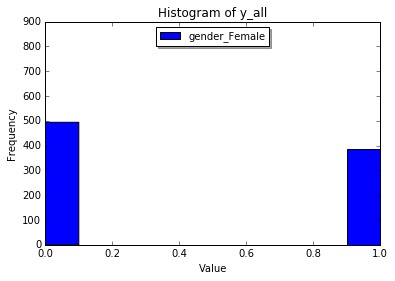

In [11]:
y_all.plot.hist()

_= pyplt.xlabel('Value')
_= pyplt.title('Histogram of y_all')
_= pyplt.legend(loc='upper center', shadow=True, fontsize='medium')
_= pyplt.yticks(np.arange(0, 1000, 100))


## Use Sklearn Function
Another approach I want to try is using sklearns feature selection function `SelectPercentile`

In [12]:
## Make sure we drop gender_Female from the table, otherwise we will be including the labeled data

student_data = student_data.drop('gender_Female', axis=1)  # feature values for all students
print "Feature column(s):-", list(student_data)

Feature column(s):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'atcsgender_1', 'atcsgender_2', 'atcsgender_3', 'atcsjob_1', 'atcsjob_2', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'classmtr', 'clet_1', 'clet_2', 'cltrcmp_1', 'cltrcmp_2', 'grade_B or above', 'grade_B or below', 'mtr_1', 'mtr_2', 'mtr_3', 'prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5', 'prepared', 'priorcs10', 'reason_class_Interested', 'reason_class_Other']


In [21]:
from sklearn.feature_selection import SelectPercentile, f_classif

# lets choose the top 10% of features that yeild the most infomation

selector = SelectPercentile(f_classif, percentile=15)
selector.fit(student_data, target_col)


features_transformed = selector.transform(student_data)

In [22]:
print"{:20}{:d}{:4}{:d}".format("Features have been reduced from ", student_data.shape[1],
                               " to", features_transformed.shape[1])


Features have been reduced from 45 to 7



### Split Data into training and testing set

#### Pro Tip:
When dealing with the new data set it is good practice to assess its specific characteristics and implement the cross validation technique tailored on those very characteristics, in our case there are two main elements:

- Our dataset is slightly unbalanced. (There are more passing students than on passing students)

We could take advantage of K-fold cross validation to exploit small data sets. Even though in this case it might not be necessary, should we have to deal with heavily unbalance datasets, we could address the unbalanced nature of our data set using Stratified K-Fold and Stratified Shuffle Split Cross validation, as stratification is preserving the preserving the percentage of samples for each class.

- http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
- http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedKFold.html

In [23]:
# First, decide how many training vs test samples you want
num_all = features_transformed.shape[0] #student_data.shape[0]  # same as len(student_data)
num_train = int(num_all * 0.75)  # about 75% of the data
num_test = num_all - num_train


#### Use new features as input to classifier

In [24]:
X_all = features_transformed

In [25]:
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset

# Test shuffle_split_data
try:
    X_train, y_train, X_test, y_test = tl.shuffle_split_data(X_all, y_all, num_train)
    print "Successfully shuffled and split the data!"
except:
    print "Something went wrong with shuffling and splitting the data."


print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Successfully shuffled and split the data!
Training set: 661 samples
Test set: 221 samples


## Modeling and Validating

#### Dictionary of models to run



In [26]:
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score


models = {'DecisionTree': tree.DecisionTreeClassifier(),
          'SVC': svm.SVC(),
          'RandomForest': RandomForestClassifier()
         }



In [29]:
from sklearn.metrics import f1_score

scores = [accuracy_score, precision_score, recall_score, f1_score]
score_list = []
model_score_list = []
model_name_list = []
prntLatex = 0 # key to print table optimized for insertion in Latex document.
    
for model_name, clf in models.iteritems():
# Fit model to the training data, and predict labels (for both training and test sets), and measure the F1 score. 
    tl.train_classifier(clf, X_train, y_train)
    train_time, F1_score_train, F1_score_test, prediction_time_test = tl.train_predict(clf, 
                                                                        X_train, y_train, X_test, y_test)
    tl.makeTable(clf, X_train, y_train, X_test, y_test, prntLatex)

    print "\n"

                               RandomForestClassifier
                                    Training set size
                              200	400	600
-------------------------------------------------------
Training time (secs)          0.020	0.022	0.020
Prediction time (secs)        0.001	0.001	0.001
F1 score for training set     0.927	0.909	0.966
F1 score for test set         0.564	0.557	0.492


                               DecisionTreeClassifier
                                    Training set size
                              200	400	600
-------------------------------------------------------
Training time (secs)          0.001	0.001	0.000
Prediction time (secs)        0.000	0.000	0.000
F1 score for training set     0.964	0.933	0.989
F1 score for test set         0.562	0.564	0.558


                                                  SVC
                                    Training set size
                              200	400	600
--------------------------------------------------

In [30]:
for model_name, clf in models.iteritems():
    # Create confusion matrix
    tl.makeConfusionMatrix(clf, X_test, y_test)
    print '\n\n'

         RandomForestClassifier         
                           Actual Gender
Predicted                Female    Male      
               Female    81.000    30.000    
               Male      56.000    54.000    



         DecisionTreeClassifier         
                           Actual Gender
Predicted                Female    Male      
               Female    76.000    35.000    
               Male      53.000    57.000    



                  SVC                   
                           Actual Gender
Predicted                Female    Male      
               Female    93.000    18.000    
               Male      69.000    41.000    





# Tune Model
## Proposed Procedure

1. Transform data to the format of an SVM package
2. Conduct simple scaling on the data
- Consider the RBF kernel K(x, y)
- Use cross-validation to find the best parameter C and γ
- Use the best parameter C and γ to train the whole training set
- Test

In [ ]:
# TODO: Fine-tune your model and report the best F1 score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit

# Build a stratified shuffle object because of unbalanced data
ssscv = StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.3)

# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = 10. ** np.arange(-3, 5)
gamma_range = 2. ** np.arange(-5, 1)
kernel_list = ['rbf']

param_grid = dict(kernel=kernel_list, gamma=gamma_range, C=C_range)

f1_scorer = make_scorer(f1_score)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=ssscv, scoring=f1_scorer)

grid.fit(X_train, y_train)

print("The best classifier is: ", grid.best_estimator_)

## Validating the Model

In [ ]:
print "{:>33}".format(grid.__class__.__name__)
print "-"*35

print "{:30}{:.3f}".format('F1 score for training set' ,grid.score(X_train, y_train))
print "{:30}{:.3f}".format('F1 score for test set' ,grid.score(X_test, y_test))
print "\nBest params: {}".format( grid.best_params_ )

In [ ]:
# grid_scores_ contains parameter settings and scores
score_dict = grid.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Make a nice figure
pyplt.figure(figsize=(10, 6))
pyplt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pyplt.imshow(scores, interpolation='nearest', cmap=pyplt.cm.coolwarm)
pyplt.title('Gamma versus C for SVM')
pyplt.xlabel('gamma')
pyplt.ylabel('C')
pyplt.colorbar()
pyplt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
pyplt.yticks(np.arange(len(C_range)), C_range)
pyplt.show()


## Bias $C$ to correct for class imbalance

As previously stated, there are more examples of student success than failure. As such, the optimal learner for this problem is one that can still generate reasonable classification given the unbalanced dataset. SVMs have a method of *biasing* the soft-margin constant, $C$, to correct for class imbalances. 
- The solution is to assign a different soft-margin constant to each class.

## Pipelining
You could actually go well beyond grid search and implement ‘pipelines’ where the whole machine learning process becomes 'grid-searchable' and you can parameterize and search the whole process though cross validation.
http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

And yes you can try out several algorithms automatically as well too! Watch out though this is pretty advanced stuff, here is a great, informative, top notch tutorial from Zac Sewart!
http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html

## Feature Selection 
### Random Forest Classifier

Random forests are a popular method for feature ranking, since they are so easy to apply: in general they require very little feature engineering and parameter tuning and mean decrease impurity is exposed in most random forest libraries. But they come with their own gotchas, especially when data interpretation is concerned. With correlated features, strong features can end up with low scores and the method can be biased towards variables with many categories. As long as the gotchas are kept in mind, there really is no reason not to try them out on your data. [Diving into data blog](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/)

In [ ]:
## Lets find important features
## Feature ranking

from sklearn.ensemble import RandomForestClassifier
import operator

def getImportantFeatures(n=1, topNFeatures=5):
    """Retrieve top N features.

    Keyword arguments:
    n -- the number of times you want to run the classifier, knowing that it randomizes its seed (int)
    topNFeatures -- top n features of interest (int)
    """
    names = X_train.columns
    rf = RandomForestClassifier()
    featuresSortedByScore = list()

    for i in range(n):
        rf.fit(X_train, np.ravel(y_train))
        featuresSortedByScore.append(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))
        
    # Get top features through tally

    myTopFeature = {}
    for i in range (len(featuresSortedByScore)):
        for j in range (topNFeatures):
            if featuresSortedByScore[i][j][1] not in myTopFeature.keys():
                myTopFeature[featuresSortedByScore[i][j][1]] = 1
            else:
                myTopFeature[featuresSortedByScore[i][j][1]] += 1


    return sorted(myTopFeature.items(), key=operator.itemgetter(1), reverse=True)[:topNFeatures]
    

In [ ]:
n = 100
topNFeatures = 10
newFeatures = getImportantFeatures(n, topNFeatures)

for i in range(len(newFeatures)):
    print newFeatures[i]


### Assign new features

In [ ]:
newFeatures
newCols = []

for col, _ in newFeatures:
    newCols.append(col)

In [ ]:
df = student_data[newCols]
len(df.columns)